In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
def convert_timestamp_columns(df):
    df["DATE_START"] = pd.to_datetime(df["TIMESTAMP_START"].str.split(" ").str[0])
    df["TIME_START"] = df["TIMESTAMP_START"].str.split(" ").str[1]
    df["DATE_MID"] = pd.to_datetime(df["TIMESTAMP_MITTE"].str.split(" ").str[0])
    df["TIME_MID"] = df["TIMESTAMP_MITTE"].str.split(" ").str[1]
    df["DATE_END"] = pd.to_datetime(df["TIMESTAMP_ENDE"].str.split(" ").str[0])
    df["TIME_END"] = df["TIMESTAMP_ENDE"].str.split(" ").str[1]
    df = df.drop(["TIMESTAMP_START", "TIMESTAMP_MITTE", "TIMESTAMP_ENDE"], axis=1)
    return df


def process_flux_data(df):
    df = df.drop(0)
    # drop NaN flux data
    df = df.dropna(subset=["H_f"])
    df = convert_timestamp_columns(df)
    # adjust dtypes
    df["H_f"] = df["H_f"].astype(float)
    df["LE_f"] = df["LE_f"].astype(float)
    df["NEE_f"] = df["NEE_f"].astype(float)
    return df


def process_bog_data(path_flux, path_meteo):
    df1 = pd.read_csv(path_flux)
    df2 = pd.read_csv(path_meteo)
    # drop first row that contains units
    df2 = df2.drop(0)
    # extract dates and times
    df2 = convert_timestamp_columns(df2)
    df1 = process_flux_data(df1)
    df_fluxes = df1.groupby("TIME_START").agg(H=("H_f", "mean"), LE=("LE_f", "mean"))
    df2["Q"] = df2["Nettostrahlung_300cm"].astype(float)
    df2["G"] = df2["Bodenwaermefluss"].astype(float)
    df_meteo = df2.groupby("TIME_START").agg(Q=("Q", "mean"), G=("G", "mean"))
    df_joined = df_fluxes.merge(df_meteo, on="TIME_START")
    df_joined["H+G+LE"] = df_joined["H"] + df_joined["G"] + df_joined["LE"] 
    df_joined["res"] = df_joined["Q"] - df_joined["H+G+LE"]
    return df_joined


    



<Axes: xlabel='TIME_START'>

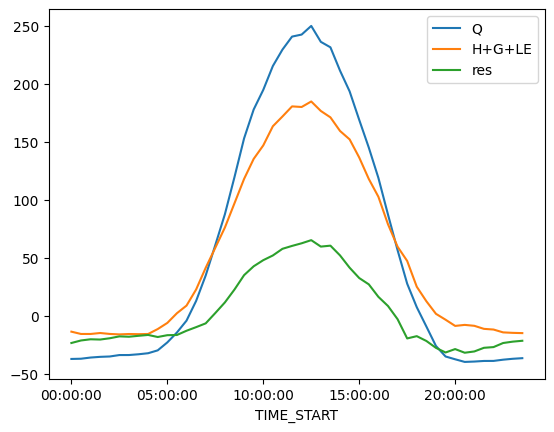

In [143]:
# botanical garden
path_flux_bog = "Fluxes_H_LE_CO2/BoG/FBG_fluxes_30min_20230101_20230801.csv"
path_meteo_bog = "Meteo/BoG/FBG_meteo_30min_20230101_20230801.csv"


df_bog = process_bog_data(path_flux_bog, path_meteo_bog)
df_bog[["Q", "H+G+LE", "res"]].plot()


In [145]:
# göttingen forest
path_flux_goew = "Fluxes_H_LE_CO2/GoeWa/GoeW_fluxes_30min_20230101_20230801.csv"
path_meteo_goew = "Meteo/GoeWa/GoeW_meteo_30min_20230101_20230801.csv"
path_soil_goew = "Meteo/GoeWa/GoeW_soil_10min_20230101_20230801.csv"

df1 = pd.read_csv(path_flux_goew)
df1 = process_flux_data(df1)
df2 = pd.read_csv(path_meteo_goew)
df3 = pd.read_csv(path_soil_goew)
df2 = df2.drop(0)
df3 = df3.drop(0)
df2 = convert_timestamp_columns(df2)
df3 = convert_timestamp_columns(df3)


# extract min and max data
min_date = df1["DATE_START"].min()
max_date = df1["DATE_START"].max()
# filter meteo and soil data for min and max date
df2 = df2[(min_date <= df2["DATE_START"]) & (df2["DATE_START"] <= max_date)]
df3 = df3[(min_date <= df3["DATE_START"]) & (df3["DATE_START"] <= max_date)]

# adjust dtypes
df2["kurzwAusstrahlun_43m"] = df2["kurzwAusstrahlun_43m"].astype(float)
df2["kurzwEinstrahlung_43m"] = df2["kurzwEinstrahlung_43m"].astype(float)
df2["Q"] = -df2["kurzwEinstrahlung_43m"] - df2["kurzwAusstrahlun_43m"]



,kurzwEinstrahlung_43m,kurzwAusstrahlun_43m,langwEinstrahlung_43m,langwAusstrahlung_43m,Luftdruck_43m,Lufttemperatur_43m,RelativeFeuchte_43m,Wasserdampfdruck_43m,Wasserdampfdefizit_43m,Niederschlag_43m,...,Bodentemp_1_30cm,Bodentemp_2_30cm,Bodentemp_3_30cm,Bodentemp_4_30cm,DATE_START,TIME_START,DATE_MID,TIME_MID,DATE_END,TIME_END
6097,-1.4413333333333334,1.0396666666666667,290.60952319876077,346.99218986542746,965.0,6.626,87.16666666666667,8.518393250225428,1.2541420272798423,0.0,...,NaN,9.630899000000001,9.5450525,9.330344,2023-05-08,00:00:00,2023-05-08,00:15:00,2023-05-08,00:30:00
6098,-1.5143333333333333,1.0413333333333334,287.7363987486472,345.1067320819805,965.0,6.241333333333334,87.89999999999999,8.364762360631639,1.1514633056159607,0.0,...,NaN,9.630899000000001,9.5021235,9.316023,2023-05-08,00:30:00,2023-05-08,00:45:00,2023-05-08,01:00:00
6099,-1.4606666666666668,0.9923333333333332,290.8741381748564,343.25447150818974,965.0,5.837,88.86666666666667,8.223015245250856,1.0301902070194249,0.0,...,NaN,9.630899000000001,9.487808,9.330344,2023-05-08,01:00:00,2023-05-08,01:15:00,2023-05-08,01:30:00
6100,-1.3296666666666666,1.0076666666666665,293.59247423236604,341.7321408990327,965.0,5.4799999999999995,89.89999999999999,8.114657711643025,0.9116578741667922,0.0,...,NaN,9.630899000000001,9.487808,9.316023,2023-05-08,01:30:00,2023-05-08,01:45:00,2023-05-08,02:00:00
6101,-1.2346666666666668,1.0120000000000002,293.4864928453892,340.73749284538917,965.0,5.271333333333334,90.5,8.050860500516757,0.8451179530929185,0.0,...,NaN,9.6433,9.4859045,9.342751,2023-05-08,02:00:00,2023-05-08,02:15:00,2023-05-08,02:30:00
